In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:6 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,123 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,825 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubunt

In [ ]:
# Créer une session Spark
spark = SparkSession.builder.appName("CarPriceML").getOrCreate()

In [ ]:
df = spark.read.format('csv').options(header='true').load("/content/drive/MyDrive/Colab Notebooks/car-details-6907d327d0b64090463185.csv")

In [ ]:
df.show()

+--------------------+--------+------+--------------------+----+------+------+-----------+------------+---------+-----------+---------+-------------+------------------+-----+-------------+
|                name| company| model|             edition|year| owner|  fuel|seller_type|transmission|km_driven|mileage_mpg|engine_cc|max_power_bhp|         torque_nm|seats|selling_price|
+--------------------+--------+------+--------------------+----+------+------+-----------+------------+---------+-----------+---------+-------------+------------------+-----+-------------+
|Maruti Swift Dzir...|  Maruti| Swift|           Dzire VDI|2014| First|Diesel| Individual|      Manual|   145500|       55.0|   1248.0|         74.0|             190.0|  5.0|       450000|
|Skoda Rapid 1.5 T...|   Skoda| Rapid|    1.5 TDI Ambition|2014|Second|Diesel| Individual|      Manual|   120000|       49.7|   1498.0|       103.52|             250.0|  5.0|       370000|
|Honda City 2017-2...|   Honda|  City|       2017-2020 

In [ ]:
# types de la donnee
df.printSchema()

root
 |-- name: string (nullable = true)
 |-- company: string (nullable = true)
 |-- model: string (nullable = true)
 |-- edition: string (nullable = true)
 |-- year: string (nullable = true)
 |-- owner: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- seller_type: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- km_driven: string (nullable = true)
 |-- mileage_mpg: string (nullable = true)
 |-- engine_cc: string (nullable = true)
 |-- max_power_bhp: string (nullable = true)
 |-- torque_nm: string (nullable = true)
 |-- seats: string (nullable = true)
 |-- selling_price: string (nullable = true)



In [ ]:
# Charger le CSV dans un DataFrame Pandas
# Determination du nombre de valeurs nulls par colonne
from pyspark.sql import functions as F
from functools import reduce
df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in df.columns
]).show()

# Determination des lignes dupliquee sur l'ensemble de la donnee
df.groupBy(df.columns) \
  .count() \
  .filter("count > 1") \
  .show()


# Calcule du nombre de lignes nulles communes aux colonnes qui en contiennent
cols =["mileage_mpg","engine_cc","max_power_bhp","torque_nm","seats"]
count_all_nulls = df.filter(
    reduce(lambda a, b: a & b, [F.col(c).isNull() for c in cols])
).count()

print(f"Nombre de lignes où {cols} sont toutes NULL : {count_all_nulls}")



+----+-------+-----+-------+----+-----+----+-----------+------------+---------+-----------+---------+-------------+---------+-----+-------------+
|name|company|model|edition|year|owner|fuel|seller_type|transmission|km_driven|mileage_mpg|engine_cc|max_power_bhp|torque_nm|seats|selling_price|
+----+-------+-----+-------+----+-----+----+-----------+------------+---------+-----------+---------+-------------+---------+-----+-------------+
|   0|      0|    0|      0|   0|    0|   0|          0|           0|        0|        208|      208|          209|      209|  208|            0|
+----+-------+-----+-------+----+-----+----+-----------+------------+---------+-----------+---------+-------------+---------+-----+-------------+

+----+-------+-----+-------+----+-----+----+-----------+------------+---------+-----------+---------+-------------+---------+-----+-------------+-----+
|name|company|model|edition|year|owner|fuel|seller_type|transmission|km_driven|mileage_mpg|engine_cc|max_power_bhp|to

Il n'y a que 209 lignes nulles et communes a toutes les colonnes qui en contiennent donc nous pouvons nous permettre de toutes les supprimer
De plus nous n'avons pas de valeurs dupliquee

In [ ]:
# Nettoyer les valeurs manquantes
from pyspark.sql import functions as F

# Supprime toutes les lignes ayant au moins une valeur NULL
df_clean = df.na.drop()

# Vérifier qu'il n'y a plus de NULL dans aucune colonne
df_clean.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in df_clean.columns
]).show()


+----+-------+-----+-------+----+-----+----+-----------+------------+---------+-----------+---------+-------------+---------+-----+-------------+
|name|company|model|edition|year|owner|fuel|seller_type|transmission|km_driven|mileage_mpg|engine_cc|max_power_bhp|torque_nm|seats|selling_price|
+----+-------+-----+-------+----+-----+----+-----------+------------+---------+-----------+---------+-------------+---------+-----+-------------+
|   0|      0|    0|      0|   0|    0|   0|          0|           0|        0|          0|        0|            0|        0|    0|            0|
+----+-------+-----+-------+----+-----+----+-----------+------------+---------+-----------+---------+-------------+---------+-----+-------------+



In [ ]:
# Séparer variables numériques et catégorielles
# Convertir le type des colonnes ||||||
from pyspark.sql.types import FloatType, IntegerType, StringType
df_clean = df_clean.withColumn("year", F.col("year").cast(FloatType())) \
       .withColumn("km_driven", F.col("km_driven").cast(FloatType())) \
       .withColumn("mileage_mpg", F.col("mileage_mpg").cast(FloatType())) \
       .withColumn("engine_cc", F.col("engine_cc").cast(FloatType())) \
       .withColumn("max_power_bhp", F.col("max_power_bhp").cast(FloatType())) \
       .withColumn("torque_nm", F.col("torque_nm").cast(FloatType())) \
       .withColumn("seats", F.col("seats").cast(FloatType())) \
       .withColumn("selling_price", F.col("selling_price").cast(FloatType()))

# Verifier la convertion des donnees
df_clean.printSchema()

root
 |-- name: string (nullable = true)
 |-- company: string (nullable = true)
 |-- model: string (nullable = true)
 |-- edition: string (nullable = true)
 |-- year: float (nullable = true)
 |-- owner: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- seller_type: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- km_driven: float (nullable = true)
 |-- mileage_mpg: float (nullable = true)
 |-- engine_cc: float (nullable = true)
 |-- max_power_bhp: float (nullable = true)
 |-- torque_nm: float (nullable = true)
 |-- seats: float (nullable = true)
 |-- selling_price: float (nullable = true)



In [ ]:
from pyspark.sql.types import NumericType

# Separation des differentes colonnes
numeric_cols = [f.name for f in df_clean.schema.fields if isinstance(f.dataType, NumericType)]
categorical_cols = [f.name for f in df_clean.schema.fields if isinstance(f.dataType, StringType)]

# Creation de deux dataframes
df_numeric = df_clean.select(numeric_cols)
df_categorical = df_clean.select(categorical_cols)

df_numeric.show()
df_categorical.show()



+------+---------+-----------+---------+-------------+----------+-----+-------------+
|  year|km_driven|mileage_mpg|engine_cc|max_power_bhp| torque_nm|seats|selling_price|
+------+---------+-----------+---------+-------------+----------+-----+-------------+
|2014.0| 145500.0|       55.0|   1248.0|         74.0|     190.0|  5.0|     450000.0|
|2014.0| 120000.0|       49.7|   1498.0|       103.52|     250.0|  5.0|     370000.0|
|2006.0| 140000.0|       41.6|   1497.0|         78.0| 124.54446|  5.0|     158000.0|
|2010.0| 127000.0|      54.06|   1396.0|         90.0| 219.66896|  5.0|     225000.0|
|2007.0| 120000.0|      37.84|   1298.0|         88.2|112.776474|  5.0|     130000.0|
|2017.0|  45000.0|      47.34|   1197.0|        81.86|    113.75|  5.0|     440000.0|
|2007.0| 175000.0|    0.02768|   1061.0|         57.5|  76.49187|  5.0|      96000.0|
|2001.0|   5000.0|      37.84|    796.0|         37.0|      59.0|  4.0|      45000.0|
|2011.0|  90000.0|      55.44|   1364.0|         67.1|

2️⃣ Analyse exploratoire

Statistiques descriptives et visualisations (histogrammes, boxplots)

Vérification de la distribution des variables

In [ ]:
import matplotlib.pyplot as plt

# Exemple pour la colonne "name"
df_count = df_clean.groupBy("model","edition").count().orderBy(F.desc("count"))
df_count.show()

df_count = df_clean.groupBy("model","edition").count().orderBy(F.desc("count"))
df_count.show()


+------+-----------------+-----+
| model|          edition|count|
+------+-----------------+-----+
| Swift|        Dzire VDI|  118|
|  Alto|          800 LXI|   76|
|  Alto|              LXi|   69|
| Swift|              VDI|   60|
|  Alto|          K10 VXI|   47|
|   EON|         Era Plus|   44|
|  Alto|               LX|   43|
| Wagon|      R VXI BS IV|   43|
|Ertiga|              VDI|   42|
|  Ritz|              VDi|   40|
| Swift|        Dzire VXI|   37|
|   800|               AC|   37|
| Swift|         VDI BSIV|   34|
| Swift|        Dzire VDi|   33|
|   EON|       Magna Plus|   30|
|  KWID|              RXT|   30|
| Verna|           1.6 SX|   29|
|  Alto|          800 VXI|   27|
|  Alto|K10 2010-2014 VXI|   27|
| Wagon|      R LXI Minor|   27|
+------+-----------------+-----+
only showing top 20 rows



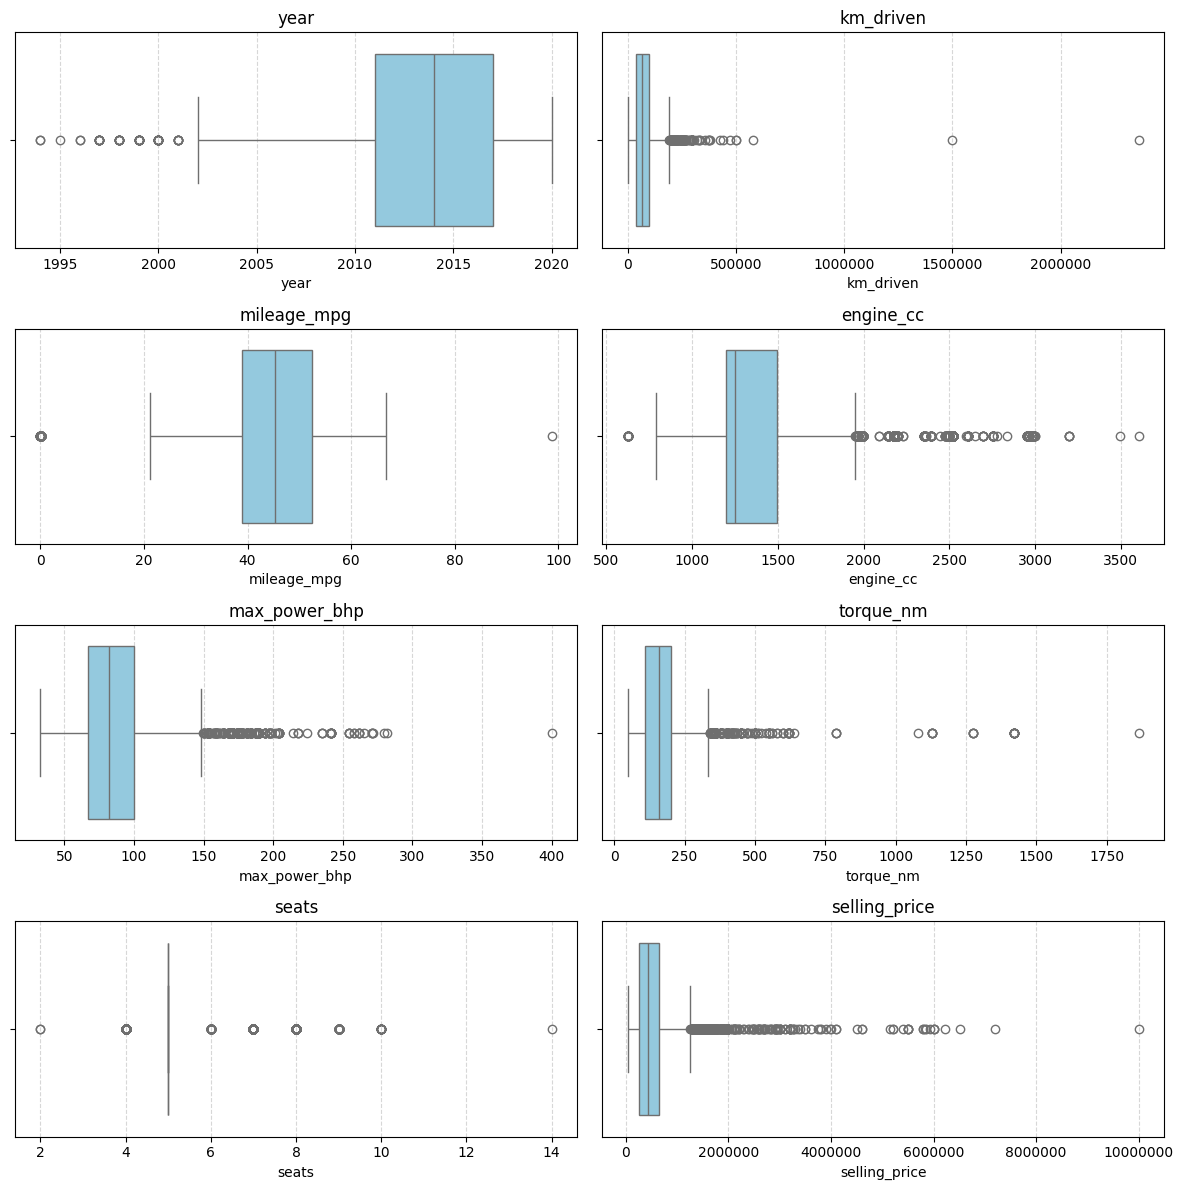

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql.types import NumericType

# 1️⃣ Identifier les colonnes numériques
numeric_cols = [f.name for f in df_clean.schema.fields if isinstance(f.dataType, NumericType)]

# 2️⃣ Convertir en Pandas (seulement colonnes numériques)
pdf = df_clean.select(numeric_cols).toPandas()

# 3️⃣ Convertir explicitement en numérique et drop NaN
for col in numeric_cols:
    pdf[col] = pd.to_numeric(pdf[col], errors='coerce')
pdf = pdf.dropna(how='all', subset=numeric_cols)  # supprime les lignes où toutes les valeurs sont NaN

# 4️⃣ Création de la figure 4x2
fig, axes = plt.subplots(4, 2, figsize=(12, 12))
axes = axes.flatten()  # pour itérer facilement sur chaque subplot

# 5️⃣ Tracé des boxplots
for i, col in enumerate(numeric_cols):
    sns.boxplot(x=pdf[col], ax=axes[i], color="skyblue")
    axes[i].set_title(col)
    axes[i].ticklabel_format(style='plain', axis='x')  # évite notation scientifique
    axes[i].grid(True, axis='x', linestyle='--', alpha=0.5)

# 6️⃣ Supprimer les axes vides si moins de 8 colonnes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [93]:
from pyspark.sql import functions as F

# df_clean.filter(F.col("selling_price") == 1.0E7).select("*").show()
# df_numeric.filter(F.col("year") < 2000).select("year").count()
# df_clean.filter(F.col("km_driven") == 1.0).select("*").show()
# df_numeric.filter(F.col("mileage_mpg") > 60).select("mileage_mpg").count()
# df_numeric.filter(F.col("engine_cc") > 3000).select("engine_cc").count()
# df_numeric.filter(F.col("max_power_bhp") > 300).select("max_power_bhp").count()
# df_numeric.filter(F.col("torque_nm") > 750).select("torque_nm").count()
df_clean.filter(F.col("seats") == 14.0).select("*").show()

# from pyspark.sql import functions as F

# # Filtrer selon toutes les conditions
# df_filtered = df_numeric.filter(
#     (F.col("selling_price") > 2000000) &
#     (F.col("year") < 2000) &
#     (F.col("km_driven") > 500000) &
#     (F.col("mileage_mpg") > 60) &
#     (F.col("engine_cc") > 3000) &
#     (F.col("max_power_bhp") > 300) &
#     (F.col("torque_nm") > 750) &
#     ((F.col("seats") <= 2) | (F.col("seats") > 10))  # la contrainte seats reste en OU
# )

# # Compter le nombre de lignes
# count_all_conditions = df_filtered.count()

# print("Nombre de lignes respectant toutes les conditions :", count_all_conditions)




+--------------------+-------+------+--------------------+------+-----+------+-----------+------------+---------+-----------+---------+-------------+---------+-----+-------------+
|                name|company| model|             edition|  year|owner|  fuel|seller_type|transmission|km_driven|mileage_mpg|engine_cc|max_power_bhp|torque_nm|seats|selling_price|
+--------------------+-------+------+--------------------+------+-----+------+-----------+------------+---------+-----------+---------+-------------+---------+-----+-------------+
|Tata Winger Delux...|   Tata|Winger|Deluxe - Flat Roo...|2010.0|First|Diesel| Individual|      Manual|  50000.0|      25.17|   1948.0|         90.0|    190.0| 14.0|     235000.0|
+--------------------+-------+------+--------------------+------+-----+------+-----------+------------+---------+-----------+---------+-------------+---------+-----+-------------+



In [75]:
df_numeric.summary().show()

+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|summary|              year|        km_driven|       mileage_mpg|         engine_cc|     max_power_bhp|         torque_nm|             seats|    selling_price|
+-------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|  count|              6717|             6717|              6717|              6717|              6717|              6717|              6717|             6717|
|   mean|2013.6111359237755|73398.33765073694| 45.08749122050886|1430.9858567813012| 87.76610036284615|174.68458446271543| 5.434271252047044|526385.9970224802|
| stddev| 3.897401568537135|58703.27526987984|10.680030666133511| 493.4691975859378|31.724555168647345|106.87624935353793|0.9838050407555449|523550.4482968819|
|    min|            1994.0|            